In [1]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, MinMaxScaler
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Читаем данные
df = pd.read_csv('/Users/admin/Desktop/AI/NY-House-Dataset.csv')

# Целевая переменная
y = df['PRICE']

# Выберем признаки, которые мы хотим оставить для обучения
columns_to_keep = ['BEDS', 'BATH', 'PROPERTYSQFT', 'STATE', 'LOCALITY', 'SUBLOCALITY']
X = df[columns_to_keep].copy()

In [3]:
# Проверим пропуски
print("Пропуски в данных:")
print(X.isnull().sum())

Пропуски в данных:
BEDS            0
BATH            0
PROPERTYSQFT    0
STATE           0
LOCALITY        0
SUBLOCALITY     0
dtype: int64


In [4]:
# Кодируем категориальные признаки
categorical_columns = ['STATE', 'LOCALITY', 'SUBLOCALITY']
X = pd.get_dummies(X, columns=categorical_columns, drop_first=True)

# Разделяем на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Размер обучающей выборки:", X_train.shape, "Целевая переменная:", y_train.shape)
print("Размер тестовой выборки:", X_test.shape, "Целевая переменная:", y_test.shape)

Размер обучающей выборки: (3840, 340) Целевая переменная: (3840,)
Размер тестовой выборки: (961, 340) Целевая переменная: (961,)


In [5]:
# Нормализация численных признаков (BEDS, BATH, PROPERTYSQFT)
# Определим числовые признаки:
numeric_columns = ['BEDS', 'BATH', 'PROPERTYSQFT'] 
scaler = StandardScaler()
X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])
X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])

In [6]:
print(X_train.dtypes)

BEDS                           float64
BATH                           float64
PROPERTYSQFT                   float64
STATE_Astoria, NY 11101           bool
STATE_Astoria, NY 11102           bool
                                ...   
SUBLOCALITY_Richmond County       bool
SUBLOCALITY_Riverdale             bool
SUBLOCALITY_Snyder Avenue         bool
SUBLOCALITY_Staten Island         bool
SUBLOCALITY_The Bronx             bool
Length: 340, dtype: object


In [7]:
# Преобразуем наши данные в тензоры
# наши признаки в X_train и X_test - это DataFrame, который можно сразу преобразовать в тензор.

class MyDataset(Dataset):
    def __init__(self, X, y):
        # X - DataFrame или numpy array, y - Series или массив
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]


    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)


train_dataset = MyDataset(X_train, y_train_log)
test_dataset = MyDataset(X_test, y_test_log)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [8]:
# Определим простую модель (однослойную)
class SimpleNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleNet, self).__init__()
        self.fc = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.fc(x)

input_size = X_train.shape[1]
output_size = 1

model_SimpleNet = SimpleNet(input_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.SGD(model_SimpleNet.parameters(), lr=0.0001)

num_epochs = 100
for epoch in range(num_epochs):
    model_SimpleNet.train()
    for inputs, targets in train_dataloader:
        optimizer.zero_grad()
        outputs = model_SimpleNet(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f'Эпоха [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
print("Обучение SimpleNet завершено")

Эпоха [10/100], Loss: 136.7375
Эпоха [20/100], Loss: 91.1427
Эпоха [30/100], Loss: 64.2943
Эпоха [40/100], Loss: 45.9829
Эпоха [50/100], Loss: 31.7082
Эпоха [60/100], Loss: 25.9466
Эпоха [70/100], Loss: 17.0612
Эпоха [80/100], Loss: 14.5158
Эпоха [90/100], Loss: 11.8017
Эпоха [100/100], Loss: 6.5054
Обучение SimpleNet завершено


In [9]:
# Модель с одним скрытым слоем (Adam)
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.hidden(x)
        x = self.relu(x)
        x = self.output(x)
        return x

model_NeuralNetwork = NeuralNetwork(input_size, 64, output_size)
optimizer = optim.Adam(model_NeuralNetwork.parameters(), lr=0.0001)
criterion = nn.MSELoss()

for epoch in range(num_epochs):
    model_NeuralNetwork.train()
    for inputs, targets in train_dataloader:
        optimizer.zero_grad()
        outputs = model_NeuralNetwork(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f'Эпоха [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
print("Обучение NeuralNetwork завершено")

Эпоха [10/100], Loss: 152.9000
Эпоха [20/100], Loss: 82.0274
Эпоха [30/100], Loss: 30.3973
Эпоха [40/100], Loss: 7.9608
Эпоха [50/100], Loss: 1.9193
Эпоха [60/100], Loss: 1.6594
Эпоха [70/100], Loss: 1.1084
Эпоха [80/100], Loss: 0.8607
Эпоха [90/100], Loss: 0.7267
Эпоха [100/100], Loss: 0.3571
Обучение NeuralNetwork завершено


In [10]:
# Модель с 3+ скрытыми слоями
class HardNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(HardNeuralNetwork, self).__init__()
        layers = []
        prev_size = input_size
        for h in hidden_sizes:
            layers.append(nn.Linear(prev_size, h))
            layers.append(nn.ReLU())
            prev_size = h
        layers.append(nn.Linear(prev_size, output_size))
        self.model = nn.Sequential(*layers)
    def forward(self, x):
        return self.model(x)

model_HardNeuralNetwork = HardNeuralNetwork(input_size, [64,32,16], output_size)
optimizer = optim.Adam(model_HardNeuralNetwork.parameters(), lr=0.001)
criterion = nn.MSELoss()

for epoch in range(num_epochs):
    model_HardNeuralNetwork.train()
    for inputs, targets in train_dataloader:
        optimizer.zero_grad()
        outputs = model_HardNeuralNetwork(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f'Эпоха [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
print("Обучение HardNeuralNetwork завершено")

Эпоха [10/100], Loss: 0.3157
Эпоха [20/100], Loss: 0.2264
Эпоха [30/100], Loss: 0.1591
Эпоха [40/100], Loss: 0.1351
Эпоха [50/100], Loss: 0.1975
Эпоха [60/100], Loss: 0.2757
Эпоха [70/100], Loss: 0.1149
Эпоха [80/100], Loss: 0.1311
Эпоха [90/100], Loss: 0.1778
Эпоха [100/100], Loss: 0.2112
Обучение HardNeuralNetwork завершено


In [11]:
# Функция для построения кривой обучения
def train_model(model, criterion, optimizer, train_dataloader, test_dataloader, num_epochs):
    train_losses = []
    test_losses = []
    for epoch in range(num_epochs):
        model.train()
        train_loss_sum = 0
        for inputs, targets in train_dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss_sum += loss.item()*inputs.size(0)
        train_loss = train_loss_sum / len(train_dataloader.dataset)
        train_losses.append(train_loss)

        model.eval()
        test_loss_sum = 0
        with torch.no_grad():
            for inputs, targets in test_dataloader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                test_loss_sum += loss.item()*inputs.size(0)
        test_loss = test_loss_sum / len(test_dataloader.dataset)
        test_losses.append(test_loss)

        if (epoch+1)%10==0:
            print(f'Эпоха [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

    plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Learning Curve')
    plt.legend()
    plt.show()

Эпоха [10/50], Train Loss: 68.7513, Test Loss: 51.5080
Эпоха [20/50], Train Loss: 2.2309, Test Loss: 1.8985
Эпоха [30/50], Train Loss: 1.0446, Test Loss: 0.9290
Эпоха [40/50], Train Loss: 0.5929, Test Loss: 0.5755
Эпоха [50/50], Train Loss: 0.4108, Test Loss: 0.4335


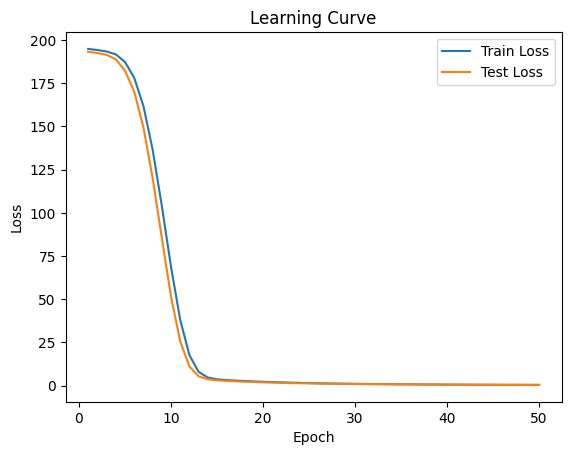

In [12]:
# Обучим модель HardNeuralNetwork заново для построения кривой обучения
model_plot = HardNeuralNetwork(input_size, [64,32,16], output_size)
optimizer_plot = optim.Adam(model_plot.parameters(), lr=0.0001)
criterion = nn.MSELoss()
train_model(model_plot, criterion, optimizer_plot, train_dataloader, test_dataloader, num_epochs=50)

In [13]:
# Подсчет MAE
def calculate_mae(model, data_loader):
    model.eval()
    mae = 0.0
    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)
            mae += torch.abs(outputs - targets).sum().item()
    mae /= len(data_loader.dataset)
    return mae

train_mae_SimpleNet = calculate_mae(model_SimpleNet, train_dataloader)
test_mae_SimpleNet = calculate_mae(model_SimpleNet, test_dataloader)

print(f'MAE на train множестве SimpleNet: {train_mae_SimpleNet:.4f}')
print(f'MAE на test множестве SimpleNet: {test_mae_SimpleNet:.4f}')

train_mae_NeuralNetwork = calculate_mae(model_NeuralNetwork, train_dataloader)
test_mae_NeuralNetwork = calculate_mae(model_NeuralNetwork, test_dataloader)

print(f'MAE на train множестве NeuralNetwork: {train_mae_NeuralNetwork:.4f}')
print(f'MAE на test множестве NeuralNetwork: {test_mae_NeuralNetwork:.4f}')

train_mae_HardNeuralNetwork = calculate_mae(model_HardNeuralNetwork, train_dataloader)
test_mae_HardNeuralNetwork = calculate_mae(model_HardNeuralNetwork, test_dataloader)

print(f'MAE на train множестве HardNeuralNetwork: {train_mae_HardNeuralNetwork:.4f}')
print(f'MAE на test множестве HardNeuralNetwork: {test_mae_HardNeuralNetwork:.4f}')

MAE на train множестве SimpleNet: 2.4298
MAE на test множестве SimpleNet: 2.4297
MAE на train множестве NeuralNetwork: 0.4898
MAE на test множестве NeuralNetwork: 0.5232
MAE на train множестве HardNeuralNetwork: 0.3026
MAE на test множестве HardNeuralNetwork: 0.3725
